In [1]:
import numpy as np
# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact
import h5py
import os
import datetime
import xml.etree.ElementTree as ET
from tifffile import imsave
from tifffile import imread
from scipy.signal import butter, filtfilt
try:
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai')
except:
    print('no style')


In [2]:
def hdfToTiff(path,hdfDataSet):
    imsave(path,np.swapaxes(np.swapaxes(hdfDataSet,0,2),1,2))
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def convertResFrame(rawFrame,linePx,tLines,sampPerPx):
    
    fullResLinePx=int(linePx*sampPerPx*2)
    resLines=int(tLines*0.5)
    halfResLinePx=int(linePx*sampPerPx)
    cFr=np.reshape(rawFrame,(resLines,fullResLinePx))
    cFr=np.reshape(cFr,(tLines,int(linePx*sampPerPx)))
    cFr[0:halfResLinePx:2,:]=np.fliplr(cFr[0:halfResLinePx:2,:])

    return cFr

In [3]:
# ******************************
# Batch Decode Raw
# ******************************

animalName="cdSom3d"
savePath='/Users/cad/Documents/cdSom3/'
basePath="/Users/cad/Documents/cdSom3/raw/"

parentDir=sorted(os.listdir(basePath))

sIDs=[]
tIDs=[]
zIDs=[]


singles=sorted([x for x in parentDir if 'Single' in x])
for n in range(0,len(singles)):
    sIDs.append("single_" + singles[n][len(singles[n])-3:len(singles[n])])

    
tSeries=sorted([x for x in parentDir if 'TSeries' in x])
for n in range(0,len(tSeries)):
    tIDs.append("tSeries_" + tSeries[n][len(tSeries[n])-3:len(tSeries[n])])
    

    
zSeries=sorted([x for x in parentDir if 'ZSeries' in x])
for n in range(0,len(zSeries)):
    zIDs.append("zSeries_" + zSeries[n][len(zSeries[n])-3:len(zSeries[n])])
    
cTime = datetime.datetime.now()
convertDate=cTime.strftime("%m%d%Y")
    
allSubPaths=singles+tSeries+zSeries
allDataIDs=sIDs+tIDs+zIDs
xmlz=[]
for n in range(0,len(allSubPaths)):
    j=os.listdir(basePath+allSubPaths[n])
    tXML=sorted([x for x in j if 'xml' in x])
    try:
        xmlz.append(tXML[0])
    except:
        xmlz.append([])

In [4]:
for cL in range(0,len(allSubPaths)):
    xmlPath=basePath + allSubPaths[cL] + "/" + xmlz[cL]
    dataPath=basePath + allSubPaths[cL] + "/"
    dataSet=allDataIDs[cL]

    tree = ET.parse(basePath + allSubPaths[cL] + "/" + xmlz[cL])
    xRoot=tree.getroot()

    # The date is in the root as part of a date/time string.
    scanDate=xRoot.attrib['date'][0:10]
    labDate=xRoot.attrib['date'][0:10]
    tSP=""
    for x in range(0,len(scanDate.split('/'))):
        tSP=tSP+scanDate.split('/')[x]
    scanDate=int(tSP)
    tSP=[]
    numChan=0
    # The frame time (interval) is the sample rate.
    frameInt=float(xRoot[1][5].attrib['value'])
    lineCount=int(xRoot[1][12].attrib['value'])
    pixelsPerLine=int(xRoot[1][20].attrib['value'])
    scanType=xRoot[1][0].attrib['value']
    pockelVal=float(xRoot[1][11][0].attrib['value'])
    pmtVal_red=float(xRoot[1][21][1].attrib['value'])
    pmtVal_green=float(xRoot[1][21][2].attrib['value'])
    if pmtVal_red>0:
        numChan=numChan+1
    if pmtVal_green>0:
        numChan=numChan+1
    print("debug chan _ {}".format(numChan))
    pos_X=float(xRoot[1][22][0][0].attrib['value'])
    pos_Y=float(xRoot[1][22][1][0].attrib['value'])
    pos_Z=float(xRoot[1][22][2][0].attrib['value'])

    multSamp=int(xRoot[1][26].attrib['value'])
    pixelsPerFrame=int(pixelsPerLine*lineCount*multSamp)
    gg=xRoot[2].findall('Frame')
    bTime_rel=[]
    bTime_abs=[]
    for x in range(0,len(gg)):
        bTime_rel.append(float(gg[x].attrib['absoluteTime']))
        bTime_abs.append(float(gg[x].attrib['relativeTime']))
        
    
    rawDir=os.listdir(dataPath)
    rawFiles=sorted([x for x in rawDir if 'CYCLE' in x])

    framesInChunks=[]
    pxSizes=[]
    rdc=np.array([])
    if len(rawFiles)>0:
        for n in range(0,len(rawFiles)):
            curFile=dataPath+rawFiles[n]
            tsZ=np.fromfile(curFile, dtype="uint16").size
            framesInChunks.append(int(tsZ/pixelsPerFrame))
            pxSizes.append(tsZ)

            actualFrameCount=len(bTime_abs)
            totalFrames=int(np.sum(pxSizes)/pixelsPerFrame)
            bAr=np.zeros(int(np.sum(pxSizes)),dtype='uint16')

            lastStrt=0
            curSz=0
            
        for n in range(0,len(rawFiles)):

            curFile=dataPath+rawFiles[n]
            tAr=np.fromfile(curFile, dtype='uint16')
            curSz=int(tAr.size)
            bAr[lastStrt:lastStrt+curSz]=tAr
            lastStrt=lastStrt+curSz
            tAr=[]

            framAr=np.zeros((lineCount,pixelsPerLine,totalFrames),dtype='uint16')

            bitMax=2**13
            rawMin=int(np.amin(bAr))
            zPt=bitMax-rawMin
            offs=bitMax-zPt
            bAr=bAr-offs

            lnPx=lineCount*pixelsPerLine*multSamp
            
        cIM=0
        for z in range(0,totalFrames-1,numChan):
            for n in range(0,numChan):
                strInd=(cIM*lnPx*numChan)+n
                endInd=((cIM*lnPx)+lnPx)*numChan+n
                indDelta=numChan
                rwDt=bAr[strInd:endInd:indDelta]
                aa=convertResFrame(rwDt,pixelsPerLine,lineCount,multSamp)
                bb=np.reshape(aa,(aa.shape[0],int(aa.shape[1]/multSamp),multSamp))
                aa=[]
                rwDt=[]
                framAr[:,:,z+n]=np.mean(bb,axis=2).astype('uint16')
                bb=[]
            cIM=cIM+1
            if np.mod(z,200)==0:
                print('on image: {}'.format(cIM))
                
        bAr=[]
        try:
            f = h5py.File(savePath+"{}_{}.hdf".format(animalName,scanDate), "a")
        except:
            print("hdf already opened")

        f[dataSet]=framAr[:,:,0:actualFrameCount*numChan]
        f[dataSet+"_absTime"]=bTime_abs
        f.close()
        framAr=[]
        print("finished {} of {}".format(cL+1,len(allSubPaths)))

debug chan _ 2
debug chan _ 1
on image: 1
finished 2 of 16
debug chan _ 1
on image: 1
finished 3 of 16
debug chan _ 1
on image: 1
on image: 201
on image: 401
on image: 601
on image: 801
on image: 1001
finished 4 of 16
debug chan _ 1
on image: 1
on image: 201
on image: 401
on image: 601
on image: 801
on image: 1001
on image: 1201
on image: 1401
on image: 1601
on image: 1801
on image: 2001
on image: 2201
on image: 2401
on image: 2601
on image: 2801
on image: 3001
on image: 3201
on image: 3401
on image: 3601
on image: 3801
on image: 4001
on image: 4201
on image: 4401
on image: 4601
on image: 4801
on image: 5001
finished 5 of 16
debug chan _ 1
on image: 1
on image: 201
on image: 401
on image: 601
on image: 801
on image: 1001
on image: 1201
on image: 1401
on image: 1601
on image: 1801
on image: 2001
finished 6 of 16
debug chan _ 1
on image: 1
on image: 201
on image: 401
on image: 601
on image: 801
on image: 1001
on image: 1201
on image: 1401
on image: 1601
on image: 1801
on image: 2001
fini

Basic Inspection .... 

In [13]:
f.close()

In [29]:
# now, let's reopen the hdf and look at frames.
animalName='cdSom3d'
scanDate='12282017'
savePath='/Users/cad/Documents/cdSom3/'
try:
    f = h5py.File(savePath+"{}_{}.hdf".format(animalName,scanDate), "a")
except:
    print('hdf open')
# datasetNames = [n for n in f.keys()]
dLabs=sorted([x for x in f.keys() if 'Time' not in x])
tLabs=sorted([x for x in f.keys() if 'Time' in x])

# ***** Select the non-zeroed indexed run you want to look at
# ***** Also if you want a tif.
dFoc=13
renderTif=0

curData=dLabs[dFoc-1]
curTime=tLabs[dFoc-1]

# If you want a tiff instead.
if renderTif:
    hdfToTiff(savePath+"{}_{}.tif".format(animalName,curData),f[curData])

In [30]:
# now make an image browser function (ipywidgets) and we can scrub.
def browse_images(lowCut=0,highCut=15000):
    n = f[curData].shape[2]
    def view_image(ind):
        Y=f[curData][:,:,ind]
        plt.figure(50)
        plt.imshow(Y, cmap=plt.cm.gray,aspect='equal',interpolation='bicubic',vmin=lowCut,vmax=highCut)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    interact(view_image, ind=(0,n-1))

In [22]:
f[curData]

<HDF5 dataset "tSeries_015": shape (512, 512, 2000), type "<u2">

<IPython.core.display.Javascript object>


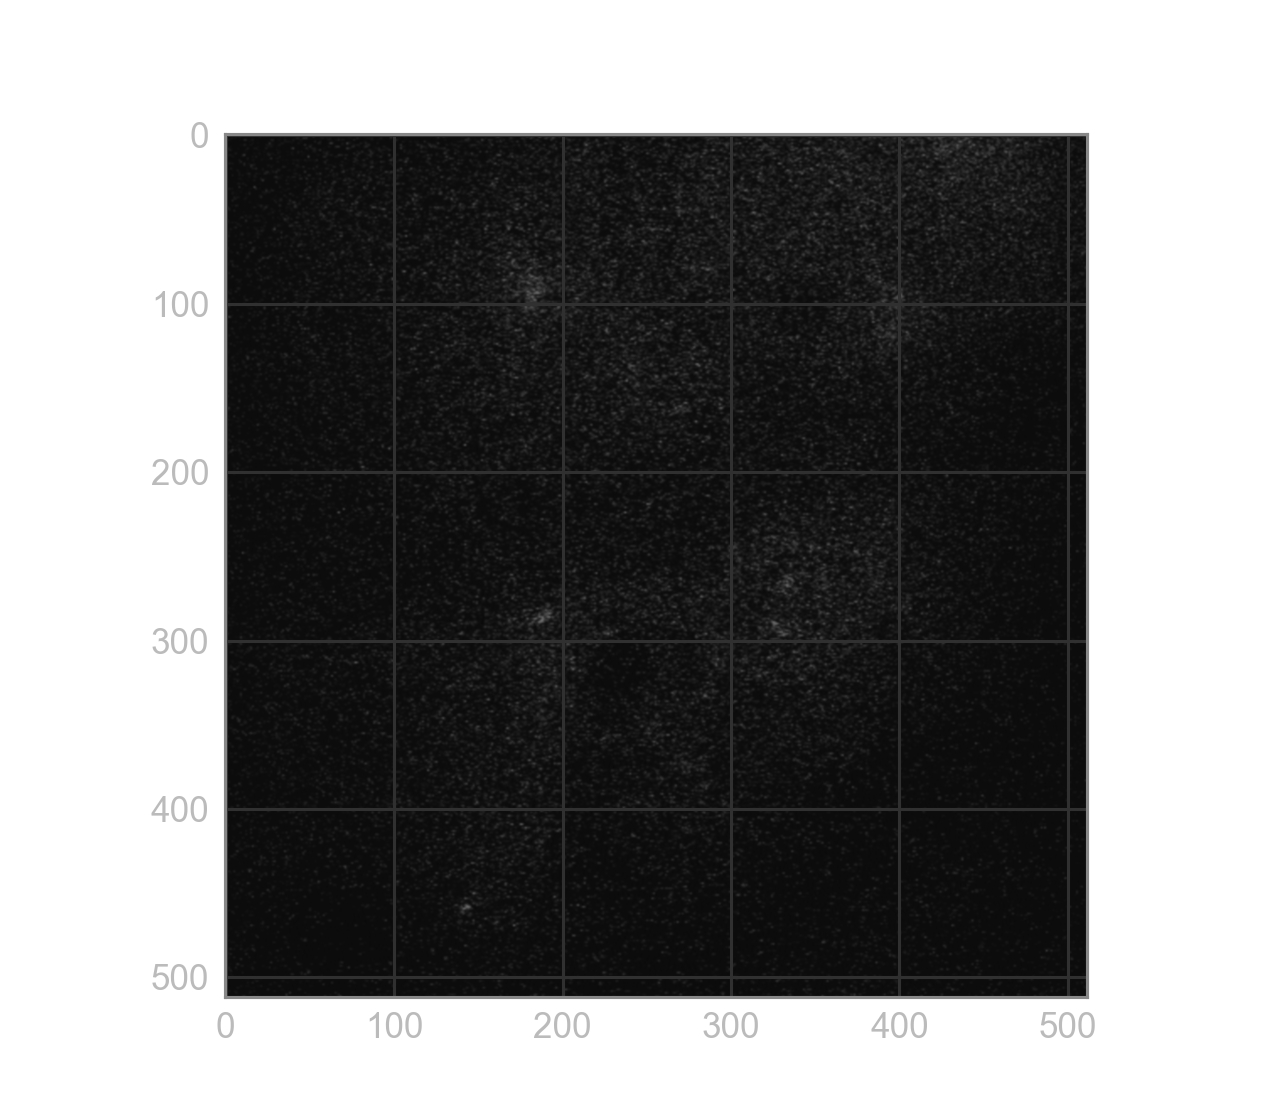

In [38]:
f[curData]
pIm=5
dPlt=f[curData][:,:,pIm]
plt.figure(51)
a=plt.imshow(dPlt,cmap=plt.cm.gray,interpolation='bicubic',aspect='equal',vmin=500,vmax=20000)

<IPython.core.display.Javascript object>


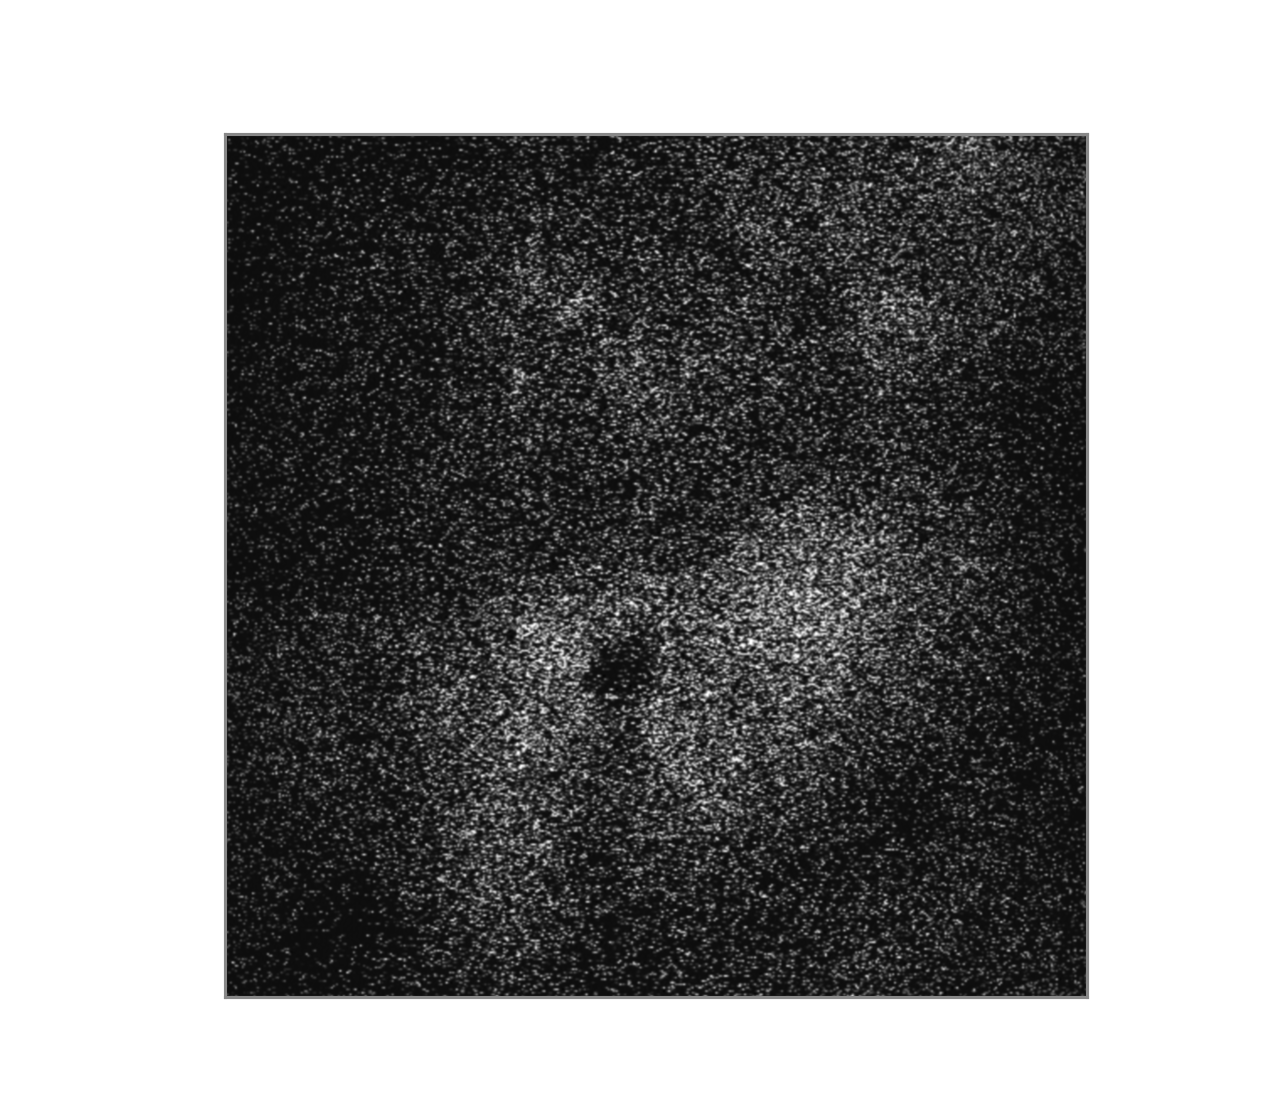

A Jupyter Widget

In [32]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        # %matplotlib inline
plt.figure(50)
browse_images(1000,9000)

In [28]:
# compute the stack's SD across frames. 
# takes a bit, has to map into memory and upsample (sums)
stdDevIm=np.std(f[curData],axis=2)

<IPython.core.display.Javascript object>


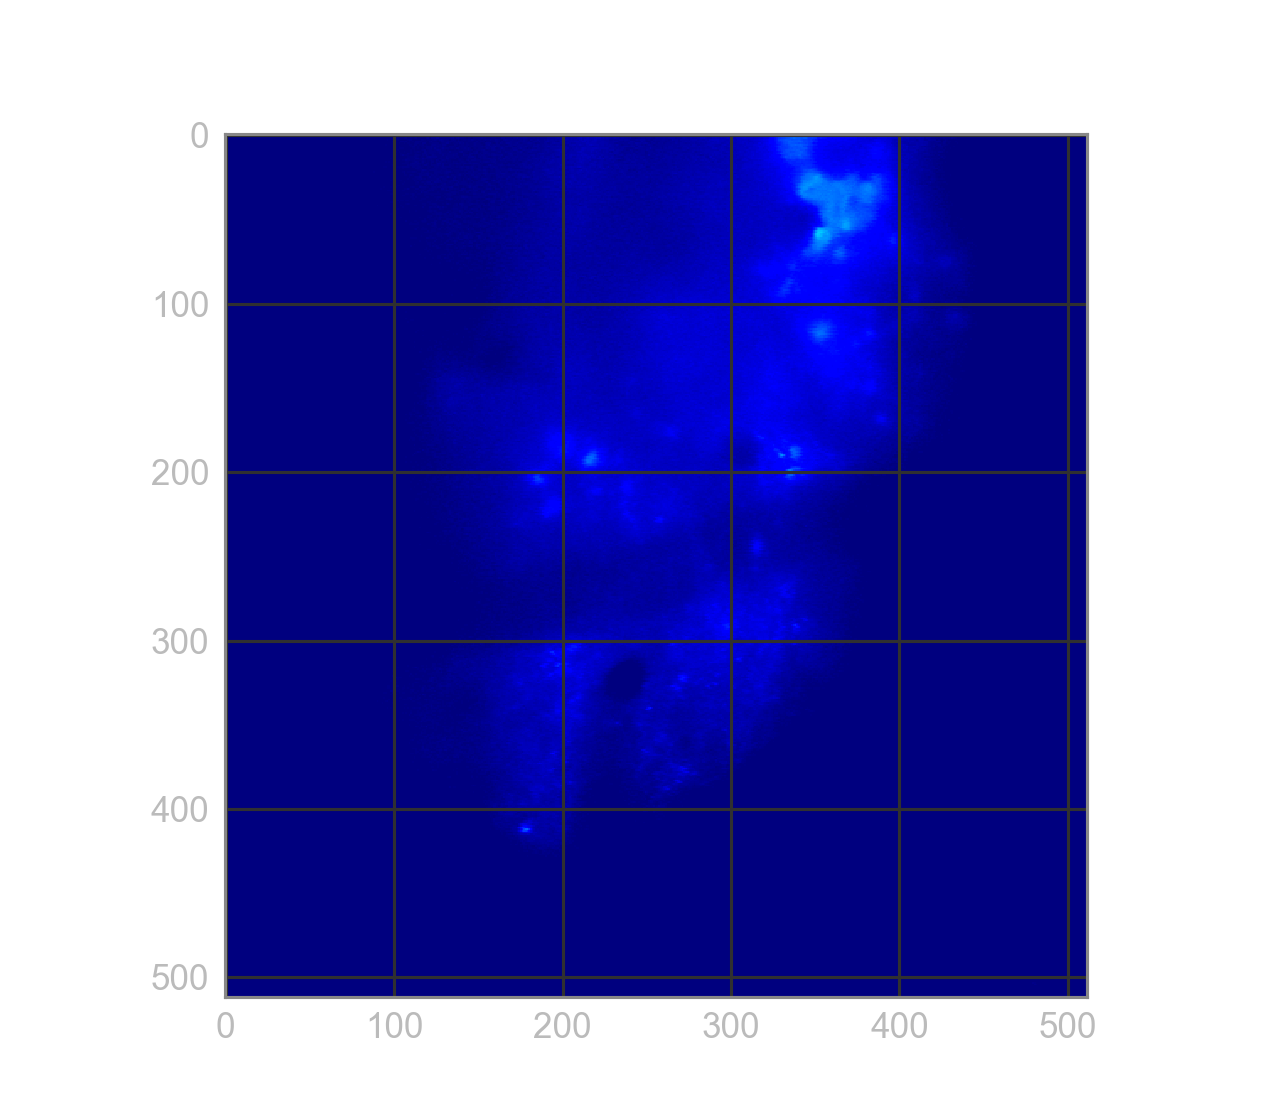

In [9]:
plt.figure(13)
stdPlot=plt.imshow(stdDevIm, cmap=plt.cm.jet,aspect='equal',vmin=500,vmax=7000)

<IPython.core.display.Javascript object>


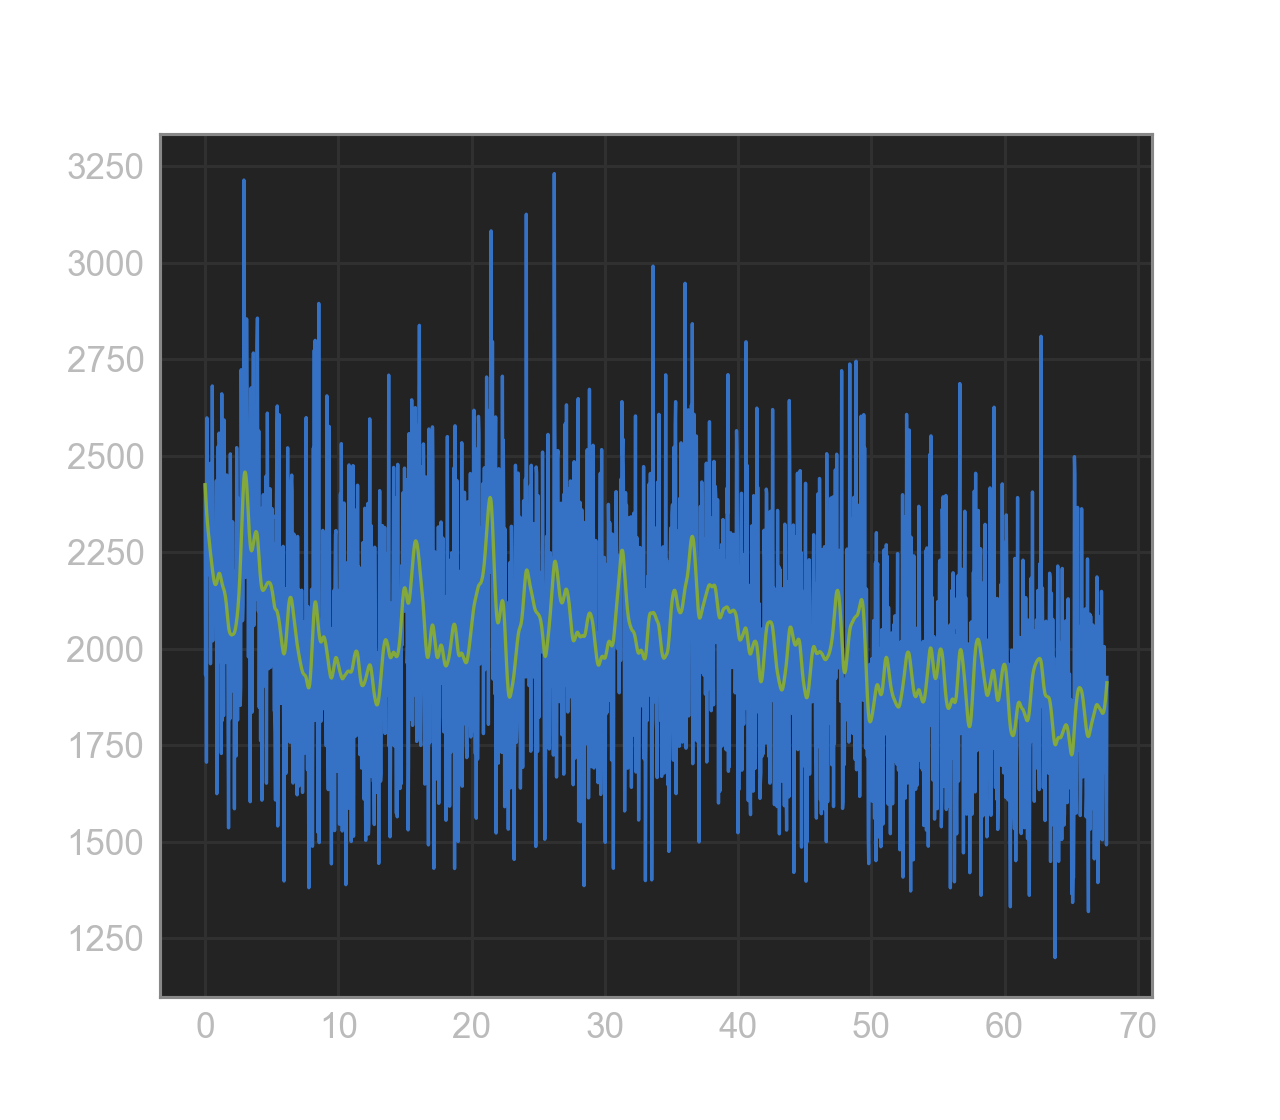

In [10]:
yDim=[411,418]
xDim=[174,180]
roi=f[curData][yDim[0]:yDim[1],xDim[0]:xDim[1],:]
roi=np.reshape(roi,(roi.shape[0]*roi.shape[1],roi.shape[2]))
roiData=np.mean(roi,axis=0)
tt=f[curTime][0:roiData.size]
fData=butter_lowpass_filtfilt(roiData, 1, 1/tt[1],2)


plt.figure(21)
plt.plot(tt,roiData,'b-')
plt.plot(tt,fData,'g-')

In [11]:
f.close()